<a href="https://www.kaggle.com/code/suntracker/mock-dev-rev?scriptVersionId=201126999" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
!pip install mistralai faiss-cpu sentence_transformers -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 17.0.0 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
xarray 2024.9.0 requires packaging>=23.1, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.10.0 requir

In [4]:
import os
from mistralai import Mistral

# Reading the tool data

In [2]:
import json

with open('/kaggle/input/dev-rev-tool/devrev_tools.json', 'r') as file:
    data = file.read()
data = json.loads(data)

for d in data:
    print(d['tool_name'])


who_am_i
get_sprint_id
works_list
summarize_objects
prioritize_objects
add_work_items_to_sprint
get_similar_work_items
search_object_by_name
create_actionable_tasks_from_text
list_sprint_work_items
filter_by_status
assign_work_items
validate_work_dependency
sync_work_items_with_calendar
list_sprint_work_items
filter_by_status
merge_work_items


## Graph based on tools

In [5]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add tools to the graph
for tool in data:
    try:
        inp = tool['args'][0]['arg_type']
    except:
        inp = None   
    G.add_node(tool['tool_name'], input_type=inp, output_type=tool['output']['arg_type'])


for tool_a in data:
    for tool_b in data:
        if (len(tool_b['args']) > 0 and tool_a != tool_b):
            for i in range(len(tool_b['args'])):
                if tool_a['output']['arg_type'] == tool_b['args'][i]['arg_type']:
                    G.add_edge(tool_a['tool_name'], tool_b['tool_name'])
                    weight = 0.1 if tool_b['args'][i].get('is_required', False) else 0.4
                    G.add_edge(tool_a['tool_name'], tool_b['tool_name'], weight=weight)

# Print graph edges (to see connections)
for edge in G.edges:
    print(f"{edge[0]} -> {edge[1]}")


who_am_i -> works_list
who_am_i -> add_work_items_to_sprint
who_am_i -> get_similar_work_items
who_am_i -> search_object_by_name
who_am_i -> create_actionable_tasks_from_text
who_am_i -> list_sprint_work_items
who_am_i -> filter_by_status
who_am_i -> assign_work_items
who_am_i -> validate_work_dependency
who_am_i -> sync_work_items_with_calendar
who_am_i -> merge_work_items
get_sprint_id -> works_list
get_sprint_id -> add_work_items_to_sprint
get_sprint_id -> get_similar_work_items
get_sprint_id -> search_object_by_name
get_sprint_id -> create_actionable_tasks_from_text
get_sprint_id -> list_sprint_work_items
get_sprint_id -> filter_by_status
get_sprint_id -> assign_work_items
get_sprint_id -> validate_work_dependency
get_sprint_id -> sync_work_items_with_calendar
get_sprint_id -> merge_work_items
works_list -> summarize_objects
works_list -> prioritize_objects
summarize_objects -> prioritize_objects
prioritize_objects -> summarize_objects
add_work_items_to_sprint -> works_list
get_sim

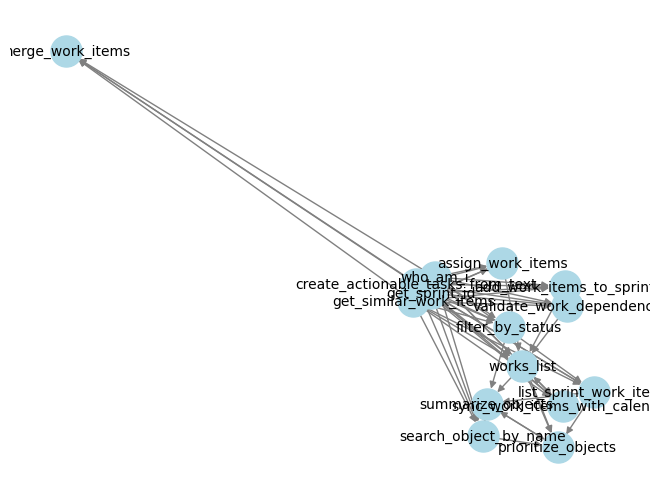

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_color='black', edge_color='gray')

# Show the graph
plt.show()


# Augmenting the tool description

In [7]:
api_key = "JCRreyWN2Q97d9C5fNzC9opl0P3jEsCT"
model = "mistral-small-latest"

client_d = Mistral(api_key=api_key)

def augment_descriptions(data, client):
    descriptions = []
    for i in range(len(data)):
        chat_response = client.chat.complete(
            model= model,
            messages = [{
                    "role": "system",
                    "content": """
                    You are an AI assistant designed to understand and explain the functionality of API tools. 
                    Your task is to analyze the given tool, break down its arguments, and generate a clear, concise, and informative description."""
                },
                {
                    "role": "assistant",
                    "content": """Your task is to provide a detailed description of the provided tool's functionality. 
                    Carefully explain each argument it accepts, how the tool works, and what kind of output it generates. 
                    Summarize its purpose in a way that highlights its use cases, keeping the explanation clear for developers. 
                    Output the description in three sentences."""
                },
                {
                    "role": "user",
                    "content": f"You are provided with the following tool, including its structure and arguments: {str(data[i])}."
                }]
            )
        descriptions.append(chat_response.choices[0].message.content)

# descriptions = [augment_description(i) for i in range(len(data))]
# descriptions = augment_descriptions(data, client)

In [8]:
descriptions = ["who_am_i: The 'who_am_i' tool is a simple API command that returns the identification of the current user, making it useful for determining user context within a system. It does not require any arguments to be passed, as the tool automatically detects and retrieves the relevant user information. The output of this tool is a string containing the user ID, which can be used in subsequent API calls or for logging and tracking purposes.",
 'get_sprint_id: The tool "get\\_sprint\\_id" is designed to retrieve the unique identifier of the currently active sprint in an agile project management system. It does not require any input arguments, as it automatically detects and fetches information about the ongoing sprint. The output of this tool is a string representing the sprint ID, which can be used for various purposes such as tracking progress, generating reports, or integrating with other tools to automate processes. In summary, get\\_sprint\\_id is a valuable tool for developers working on agile projects, providing a quick and easy way to access important sprint information.',
 "works_list: The `works_list` tool retrieves a list of work items based on the provided arguments, making it useful for filtering and managing tasks within a project. Its arguments include various options like `applies_to_part`, `created_by`, `issue_priority`, and others, which are primarily strings (some accepting arrays) or a boolean for `ticket_need_response`, allowing for flexible query customization. The tool returns a list of matching work items in any format, as indicated by the 'any' arg_type in the output description.",
 'summarize_objects: The tool "summarize\\_objects" is designed to consolidate and provide a brief overview of a list of objects, with the summarization logic varying based on the object type. It accepts a single required argument, "objects", which should be an array of any data type. The output of this tool is a single summarized object, which can be of any data type, depending on the input provided. This tool is particularly useful when dealing with large and complex data structures, where it is essential to quickly grasp the key details.',
 'prioritize_objects: The tool `prioritize_objects` is designed to accept a single input of any data type, which can optionally be an array of objects, and returns an array of objects sorted by priority. The priority logic for each object is determined internally based on specific implementation details. This tool is useful when you need to organize a collection of items based on their importance, relevance, or urgency, allowing developers to easily manage their data according to predefined priority rules.',
 'add_work_items_to_sprint: The `add_work_items_to_sprint` tool allows developers to add specified work items to a sprint by providing their unique IDs. It accepts two required arguments: `work_ids`, which is an array of strings representing the IDs of the work items, and `sprint_id`, which is a string representing the ID of the sprint to which the items will be added. The tool returns a boolean value indicating whether the operation was successful or not, making it easy to manage sprint workloads programmatically.',
 'get_similar_work_items: The "get\\_similar\\_work\\_items" tool is designed to find and return a list of work items that bear resemblance to a specified work item. It accepts a single required string argument, "work\\_id", which uniquely identifies the work item in question. Upon successful execution, the tool generates an array of strings as output, representing the IDs of the similar work items found. This tool can be useful for developers in identifying related tasks, tracking progress across connected work items, or performing data analysis on similar tasks within a project.',
 'search_object_by_name: The tool "search\\_object\\_by\\_name" is designed to find an object\'s ID in the system of record based on a provided search string. It accepts a single argument, "query", which is a required string input. The tool returns the ID of the matching object with the highest confidence if there are multiple matches. This functionality is useful for developers looking to quickly and accurately locate specific objects in their system using a simple search query.',
 'create_actionable_tasks_from_text: The "create\\_actionable\\_tasks\\_from\\_text" tool analyzes input text and identifies potential action items, generating a list of tasks as output. It requires a single string argument, \'text\', which serves as the source for task extraction. The tool\'s output is an array of strings, each representing an actionable task derived from the input text, making it useful for organizing and tracking follow-up activities based on textual data, such as emails, meeting minutes, or project documents.']

In [9]:
for i in range(len(descriptions)):
    tool = descriptions[i].split(':')[0]
    data[i]['tool_description'] = descriptions[i].split(':')[1]

In [10]:
descriptions = []

for tool in data:
    tool_n = tool['tool_name']
    args_desc = ' '.join([arg['arg_name'] + ': ' + arg['arg_description'] for arg in tool['args']])
    d = tool_n + ': ' + tool['tool_description'] + ' || Arguments: ' + args_desc
    if (d not in descriptions):
        descriptions.append(d)

len(descriptions)

16

# Retrieving tools based on L2 search

In [33]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("ToolBench/ToolBench_IR_bert_based_uncased")

def generate_embeddings(descriptions, model, t='cosine', add_tools=False, pre_index=None):
    sentences = descriptions
    embeddings = model.encode(sentences)
    
    if (t == 'cosine'):
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) # Normalize the embeddings to use cosine similarity (L2 norm of 1)
    
    embedding_dimension = embeddings.shape[1]
    
    if(add_tools):
        index = pre_index
    else:
        if (t=='cosine'):
            index = faiss.IndexFlatIP(embedding_dimension)
        else:
            index = faiss.IndexFlatL2(embedding_dimension) 

    index.add(embeddings)
    return index

index = generate_embeddings(descriptions, model, t='cosine')
print('faiss index generated')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

faiss index generated


In [34]:
def return_retrieved_tools(query, model, index, k, t='cosine'):
    query_embedding = model.encode([query])
    relevance_dict={}
    
    if (t == 'cosine'):
        query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
    distances, indices = index.search(query_embedding, k)
    
    tools = []
    for i, idx in enumerate(indices[0]):
        tool_name = descriptions[idx].split(':')[0]
        matching_tools = [tool for tool in data if tool['tool_name'] == tool_name]
        relevance_dict[tool_name] = distances[0][i]
        tools.append(str(matching_tools[0]))
    
    
    
    return (distances, indices, tools, relevance_dict)

k = 8
query = "Assign validated ’TASK-789’ and ’ISSUE-321’ to current user and sync with calendar"
distances, indices, tools, relevance_dict = return_retrieved_tools(query, model, index, k, t='cosine')

# # Step 5: Output the retrieved sentences and their distances
# print(f"Query: {query}")
# print(f"\nTop {k} similar sentences:")

# for i, idx in enumerate(indices[0]):
#     print(f"Sentence: {descriptions[idx]}")
#     print(f"Distance: {distances[0][i]:.4f}\n")

retrieved_tools = [descriptions[i].split(':')[0] for i in indices[0]]
print(relevance_dict)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'sync_work_items_with_calendar': 0.55304754, 'validate_work_dependency': 0.42462978, 'assign_work_items': 0.41474497, 'filter_by_status': 0.26579064, 'create_actionable_tasks_from_text': 0.29951364, 'prioritize_objects': 0.24405083, 'works_list': 0.1965198}


# Graph based augmentation

In [35]:
from collections import deque
import networkx as nx

def calculate_r_values(G, tools, relevance_dict, gamma):
    r_values = relevance_dict

    for tool in tools:
        queue = deque([(tool, 0, 0)])  # Track each tool with its level (depth)

        while queue:
            current_tool, level, cur_w = queue.popleft()

            
            for ancestor in G.predecessors(current_tool):
#                 print(ancestor)
                if ancestor not in r_values:
                    edge_data = G.get_edge_data(ancestor, current_tool)
                    weight = edge_data['weight']

                    t = level + 1  # Ancestor is one level higher than current tool

                    # Apply annealing factor gamma^t to the weight
                    annealed_weight = weight * (gamma ** t) + cur_w

                    if current_tool in relevance_dict:
                        r_value = relevance_dict[current_tool] * annealed_weight
                        r_values[ancestor] = r_value

                    # Add ancestor to the queue with incremented level
                    queue.append((ancestor, t, r_value))

    return r_values

r_values = calculate_r_values(G, retrieved_tools, relevance_dict, 0.9)
r_values = dict(sorted(r_values.items(), key=lambda item: item[1], reverse=True))

In [36]:
print(r_values)

{'sync_work_items_with_calendar': 0.55304754, 'validate_work_dependency': 0.42462978, 'assign_work_items': 0.41474497, 'create_actionable_tasks_from_text': 0.29951364, 'filter_by_status': 0.26579064, 'prioritize_objects': 0.24405083, 'works_list': 0.1965198, 'summarize_objects': 0.08785829901695252, 'search_object_by_name': 0.08785829901695252, 'list_sprint_work_items': 0.08785829901695252, 'add_work_items_to_sprint': 0.07074713051319123, 'who_am_i': 0.049774278402328495, 'get_sprint_id': 0.049774278402328495, 'get_similar_work_items': 0.049774278402328495}


In [43]:
k = 12 # top k matching tools
tools = [i for i in list(r_values.keys())[:k]]
print(tools)
tools_comb = []

for tool_name in tools:
    for tool in data:
        if (tool['tool_name'] == tool_name):
            tools_comb.append(str(tool))


['sync_work_items_with_calendar', 'validate_work_dependency', 'assign_work_items', 'create_actionable_tasks_from_text', 'filter_by_status', 'prioritize_objects', 'works_list', 'summarize_objects', 'search_object_by_name', 'list_sprint_work_items', 'add_work_items_to_sprint', 'who_am_i']


# Task Decomposition

In [44]:
# Convert tools to a string if it isn't already
tools_str = " ".join(tools_comb)

# Updated prompt string
prompt = """
    "You are a helpful assistant. Your job is to decompose a user query into tasks that can be solved with one tool each. 
    Tools should be taken from the fiven tool list only"
    "1. Analyse the list of tools and split the query into tasks. Solve the problem by thinking step by step. "
    "2. In each thought, think about what the next step should be in order to solve the problem, based on the available tools. "
    "Explain why the tool is required. "
    "3. Find the required tool that should be called (make sure it is related to the thought), and construct a task to be completed using it, based on the thought. "
    "If no tool is required, use 'no_tool' and return an empty list "
    "4. Ensure that each task contains the necessary information to call the tool associated with it. Do not create unnecessary steps if they haven't been mentioned in the query. "
    If the user request can’t be parsed, you need to reply empty JSON []. You should always respond in the following format:
<Solution><YOUR_SOLUTION></Solution>.
YOUR_SOLUTION> should be strict with JSON format described above.
Your knowledge base consists of tool descriptions and argument descriptions as explained below:

"""

example = """
    'Example: Query: Summarize high severity tickets from the customer (rev) UltimateCustomer and add them to the current sprint. '
    '<Solution>
    [{"thought": "First, we need to get the id of the customer UltimateCustomer","tool_name": "search_object_by_name",'
    '"task": "Use the search_object_by_name tool with the argument "query" = UltimateCustomer"},{"thought": "Next, we need to get the high severity tickets for the customer",'
    '"tool_name": "works_list","task": "Use the works_list tool with the arguments: \'issue.rev_orgs\' = "$$PREV[0]", \'ticket_severity\' = \'high\', and \'type\' = \'ticket\'."},'
    ' {"thought": "Now, we need to summarize the high severity tickets obtained from the previous task","tool_name": "summarize_objects",'
    '"task": "Use the summarize_objects tool with the output of the second task, argument \'objects\' = "$$PREV[1]"},{"thought": "In order to add the tool to the current sprint, '
    'we need to get the current sprint ID","tool_name": "get_sprint_id","task": "Use the get_sprint_id tool to get the current sprint ID"}, '
    '{"thought": "Finally, we need to add the work items obtained using works_list in the second task to the current sprint, whose ID was obtained in the previous task.",'
    '"tool_name": "add_work_items_to_sprint", "task": "Use the add_work_items_to_sprint tool with arguments \'work_ids\'=\'$$PREV[1]\' and \'sprint_id\'=\'$$PREV[3]\'"}]
    </Solution>
"""

# Combine the prompt, tools, and example
final_prompt = str(prompt) + tools_str + str(example)

# Ensure final_prompt is a string
if isinstance(final_prompt, str):
    print("final_prompt is a plain string.")
else:
    final_prompt = str(final_prompt)


final_prompt is a plain string.


In [45]:
api_key = "JCRreyWN2Q97d9C5fNzC9opl0P3jEsCT"
model = "mistral-small-latest"

client = Mistral(api_key=api_key)
chat_response = client.chat.complete(
    model=model,
    messages=[
        {
            "role": "assistant",
            "content": str(final_prompt),
        },
        {
            "role": "user",
            "content": str(query),
        },
        
    ],    
)

In [46]:
thoughts = chat_response.choices[0].message.content
print(thoughts)

```json
<Solution>
[
    {
        "thought": "First, we need to validate the work items 'TASK-789' and 'ISSUE-321'",
        "tool_name": "validate_work_dependency",
        "task": "Use the validate_work_dependency tool with the argument 'work_item_ids' = ['TASK-789', 'ISSUE-321']"
    },
    {
        "thought": "Next, we need to assign the validated work items to the current user",
        "tool_name": "assign_work_items",
        "task": "Use the assign_work_items tool with the arguments 'work_item_ids' = ['TASK-789', 'ISSUE-321'] and 'user_id' = $$PREV[0]"
    },
    {
        "thought": "Finally, we need to synchronize the assigned work items with the user's calendar",
        "tool_name": "sync_work_items_with_calendar",
        "task": "Use the sync_work_items_with_calendar tool with the arguments 'user_id' = $$PREV[1] and 'work_item_ids' = ['TASK-789', 'ISSUE-321']"
    },
    {
        "thought": "Get the current user ID",
        "tool_name": "who_am_i",
        "task": "Us

In [47]:
import re

def extract_solution(text):
    # Use regex to find text between <Solution> and </Solution> tags
    match = re.search(r'<Solution>(.*?)</Solution>', text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return None  

def extract_tools(thoughts):
    thoughts = json.loads(thoughts)
    tool_names = [item["tool_name"] for item in thoughts if "tool_name" in item]
    tools = []
    print(tool_names)
#     print(tool_names)
    for tool in tool_names:
#         print(tool)
        matching_tools = [tool1 for tool1 in data if tool1['tool_name'] == tool]
        print(matching_tools)
        tools.append(matching_tools[0])
    return tools
thoughts = extract_solution(chat_response.choices[0].message.content)
print(thoughts)
tools = extract_tools(thoughts)

print(tools)

[
    {
        "thought": "First, we need to validate the work items 'TASK-789' and 'ISSUE-321'",
        "tool_name": "validate_work_dependency",
        "task": "Use the validate_work_dependency tool with the argument 'work_item_ids' = ['TASK-789', 'ISSUE-321']"
    },
    {
        "thought": "Next, we need to assign the validated work items to the current user",
        "tool_name": "assign_work_items",
        "task": "Use the assign_work_items tool with the arguments 'work_item_ids' = ['TASK-789', 'ISSUE-321'] and 'user_id' = $$PREV[0]"
    },
    {
        "thought": "Finally, we need to synchronize the assigned work items with the user's calendar",
        "tool_name": "sync_work_items_with_calendar",
        "task": "Use the sync_work_items_with_calendar tool with the arguments 'user_id' = $$PREV[1] and 'work_item_ids' = ['TASK-789', 'ISSUE-321']"
    },
    {
        "thought": "Get the current user ID",
        "tool_name": "who_am_i",
        "task": "Use the who_am_i tool

# Final JSON formatting

In [48]:
JSON_formatting_prompt = """You are a helpful assistant. Your job is to output a json file which can be used to call the tool given
below, based on the task given to you.
You have implement the tools based on the `thoughts` given to you. Each thought corresponds to one tool.
The output of the ith task can be referenced using "$$PREV[i]" (starts from 0). This is important,
since many queries require a composition of tools.
You can't reference tools that haven't been called yet.
Tools must be explicitly called and cannot be called inside the arguments.

Output only the json format and nothing else

Example:
Query : Obtain work items from the customer support channel, summarize the ones related to part
'FEAT-345' part and prioritize them.
Completed tasks and thought process:

Task 0:
Thought: First, retrieve all work items from the customer support channel related to 'FEAT-345'
Tool_name: works_list
Task: "Use the 'works_list' tool with the arguments 'ticket.source_channel'= ['customer support']
and 'applies_to_part'= ["FEAT-345"]

Task 1:
Thought: Next, summarize the work items related to 'FEAT-345' for clarity.
Tool_name: summarize_objects
Task: Use the 'summarize_objects' tool with the 'objects' argument being the output from the
'works_list' tool, 'objects'='$$PREV[0]'
Your Task:

Task 2:
Thought: Finally, prioritize the issues from the customer support channel that are urgent.
Tool_name: "prioritize_objects
Task: "Use the 'prioritize_objects' tool with the 'objects' argument being the output from the
'works_list' tool, argument 'objects' = '$$PREV[1]'

Answer:

{'tool_name': 'works_list',
'arguments': [
{'argument_name': 'ticket_source_channel', 
'argument_value': 'customer_support_channel'},
{'argument_name': 'applies_to_part',
'argument_value': "FEAT-345"
}
]
}
{'tool_name': 'summarize_objects',
'arguments': [
{'argument_name': 'objects',
'argument_value': '$$PREV[0]'}
]
}
{
"tool_name": "prioritize_objects",
"arguments": [
{
"argument_name": "objects",
"argument_value": "$$PREV[1]"
}
]
}"""

In [233]:
user_prompt = f"""
Query: {query}

Thoughts = {thoughts}

Tools = {tools}
"""

client2 = Mistral(api_key="ZmvEjEwLGWvf2XhwAztkRiUWAenXL38n")
chat_response2 = client2.chat.complete(
    model=model,
    messages=[
        {
            "role": "assistant",
            "content": str(JSON_formatting_prompt),
        },
        {
            "role": "user",
            "content": user_prompt,
        },
        
    ],
    
    
)

In [234]:
print(chat_response2.choices[0].message.content)

```json
[
    {
        "tool_name": "validate_work_dependency",
        "arguments": [
            {
                "argument_name": "work_item_ids",
                "argument_value": ["TASK-789", "ISSUE-321"]
            }
        ]
    },
    {
        "tool_name": "who_am_i",
        "arguments": []
    },
    {
        "tool_name": "assign_work_items",
        "arguments": [
            {
                "argument_name": "work_item_ids",
                "argument_value": ["TASK-789", "ISSUE-321"]
            },
            {
                "argument_name": "user_id",
                "argument_value": "$$PREV[1]"
            }
        ]
    },
    {
        "tool_name": "sync_work_items_with_calendar",
        "arguments": [
            {
                "argument_name": "user_id",
                "argument_value": "$$PREV[1]"
            },
            {
                "argument_name": "work_item_ids",
                "argument_value": ["TASK-789", "ISSUE-321"]
            }
  

In [237]:
!pip install mistral_common

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 26.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00


In [1]:
k = ```json
[
    {
        "tool_name": "validate_work_dependency",
        "arguments": [
            {
                "argument_name": "work_item_ids",
                "argument_value": ["TASK-789", "ISSUE-321"]
            }
        ]
    },
    {
        "tool_name": "who_am_i",
        "arguments": []
    },
    {
        "tool_name": "assign_work_items",
        "arguments": [
            {
                "argument_name": "work_item_ids",
                "argument_value": ["TASK-789", "ISSUE-321"]
            },
            {
                "argument_name": "user_id",
                "argument_value": "$$PREV[1]"
            }
        ]
    },
    {
        "tool_name": "sync_work_items_with_calendar",
        "arguments": [
            {
                "argument_name": "user_id",
                "argument_value": "$$PREV[1]"
            },
            {
                "argument_name": "work_item_ids",
                "argument_value": ["TASK-789", "ISSUE-321"]
            }
        ]
    }
]
```
import json

json.loads(k)

SyntaxError: invalid syntax (964075376.py, line 1)

# Token calculation

In [279]:
JSON_prompt = [
    {
        "role": "assistant",
        "content": str(JSON_formatting_prompt),
    },
    {
        "role": "user",
        "content": query,
    },
]

thoughts_prompt = [
    {
        "role": "assistant",
        "content": str(final_prompt),  # Make sure final_prompt is defined
    },
    {
        "role": "user",
        "content": query,  # Make sure query is defined
    },
]

In [280]:
from mistral_common.protocol.instruct.messages import UserMessage
from mistral_common.protocol.instruct.request import ChatCompletionRequest
from mistral_common.protocol.instruct.tool_calls import Function, Tool
from mistral_common.tokens.tokenizers.mistral import MistralTokenizer


# Initialize the tokenizer with the model name
model_name = "mistral-small-latest"
tokenizer = MistralTokenizer.from_model(model_name)

# Encode the chat completion request
tokenized_json = tokenizer.encode_chat_completion(
    ChatCompletionRequest(
        messages=JSON_prompt,
        model=model_name,
    )
)

tokens_json= tokenized_json.tokens 

print("JSON_prompt_tokens: " + str(len(tokens_json)))

tokenized_thoughts = tokenizer.encode_chat_completion(
    ChatCompletionRequest(
        messages = thoughts_prompt,
        model=model_name,
    )
)
tokens_thoughts= tokenized_thoughts.tokens
print("Thoughts_prompt_tokens " + str(len(tokens_thoughts)))


JSON_prompt_tokens: 656
Thoughts_prompt_tokens 2938
